### Project - Predict heart attack based on phisiological and physical parameters of the patient

https://www.kaggle.com/sulianova/cardiovascular-disease-dataset

### Action plan

1. Read, explore and clean all the data sets
2. Create BoxPlot for each feature
3. Plot main relations between variables to better understand the behaviour of the data.
5. Run Machine learning algorithms to train and test. The target is 0 or 1, depending on having or not a stroke.
6. Test all ML models and measure the error. Loop for different model parameters to get the optimal ones.
7. Return best possible ML model to predict stroke with this data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Dataset analysis and cleaning
1. Age | Objective Feature | age | int (days)
2. Height | Objective Feature | height | int (cm) |
3. Weight | Objective Feature | weight | float (kg) |
4. Gender | Objective Feature | gender | categorical code | 1 woman, 2 man
5. Systolic blood pressure | Examination Feature | ap_hi | int |
6. Diastolic blood pressure | Examination Feature | ap_lo | int |
7. Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
8. Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
9. Smoking | Subjective Feature | smoke | binary |
10. Alcohol intake | Subjective Feature | alco | binary |
11. Physical activity | Subjective Feature | active | binary |
12. Presence or absence of cardiovascular disease | Target Variable | cardio | binary |

In [3]:
df_stroke = pd.read_csv('stroke_predictorSet.csv', sep=';')
df_stroke.dropna(inplace=True)
original_size = df_stroke.size
original_size

910000

In [4]:
#Set appropiate column names for second dataset, according to the data in df_stroke
columns = ['Id','Age', 'Sex', 'Height', 'Weight','SystolicPressure', 'DiastolicPressure', 'Cholesterol', 'Diabetes', 'Smoker', 'Alcoholic',
           'ActiveSport','Target']
df_stroke.columns=columns

#Age was given in days, transform to years and round to closest integer
df_stroke['Age']=(df_stroke['Age']/365).astype(int) 

df_stroke.drop(axis=1, columns=['Id'], inplace=True)

In [5]:
df_stroke[df_stroke.duplicated()==True].size

38496

In [6]:
df_stroke.drop_duplicates(inplace=True) 
cleaned_size = df_stroke.size
cleaned_size

801504

In [7]:

#Caterogize diabetes column in only two catergories, 0 means normal and 1 means above normal or patient with diabetes (>100mg/dl blood sugar)
#df_stroke['Diabetes'] = pd.cut(df_stroke['Diabetes'], bins=[1,2,4],labels=[0,1], right=False)
#df_stroke['Diabetes'].astype(int)

print('Number of lost samples after cleaning stroke_predictorSet.csv: {:,.0f}%'.format((1- cleaned_size/original_size)*100))
df_stroke.head(5)

Number of lost samples after cleaning stroke_predictorSet.csv: 12%


,Age,Sex,Height,Weight,SystolicPressure,DiastolicPressure,Cholesterol,Diabetes,Smoker,Alcoholic,ActiveSport,Target
0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,47,1,156,56.0,100,60,1,1,0,0,0,0


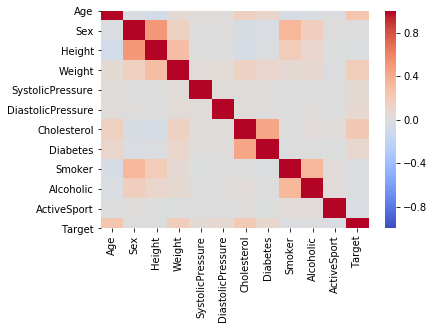

In [8]:
sns.heatmap(df_stroke.corr(), cmap='coolwarm', center=0,vmin=-1, vmax=1)

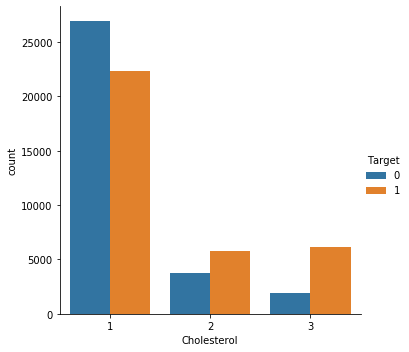

In [9]:
#We see that the target is mainly correlated to Cholesterol, Weigth and Age
sns.catplot(kind = 'count', data = df_stroke, x = 'Cholesterol', hue = 'Target');

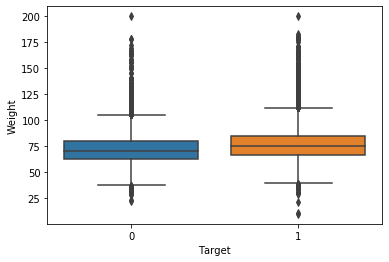

In [10]:
sns.boxplot(x='Target',y='Weight',data=df_stroke)

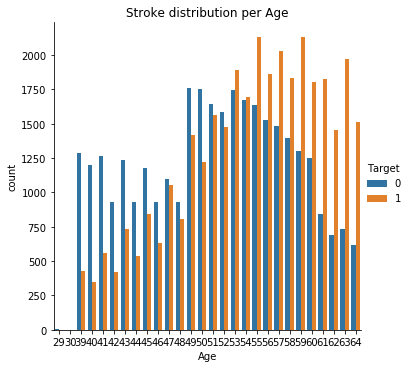

In [11]:
# Plot the target depending on the Age
sns.catplot(kind = 'count', data = df_stroke, x = 'Age', hue = 'Target', order = df_stroke['Age'].sort_values().unique());
plt.title('Stroke distribution per Age');

#The older, the higher the number of strokes.

### Machine learning models

1. Train each model

2. Error Measurements:
   2.0 calculate score
   2.1 confusion matrix - calculate and plot 
   2.2 RandomizedSearchCV - tune hyperparameters
   2.3 cross validation score
   
3. Set a dictionary with name of ML models and each error
4. After error evaluation, select the best model 

In [12]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Create target object and call it y
y = df_stroke['Target']
# Create X
#features = ['Age', 'Sex', 'SystolicPressure', 'Cholesterol', 'Diabetes']
features = ['Age', 'Sex', 'Height', 'Weight','SystolicPressure', 'DiastolicPressure', 'Cholesterol', 'Diabetes', 'Smoker', 'Alcoholic',
           'ActiveSport']
X = df_stroke[features]

# Split into validation and training data
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.4, random_state=1)

#Create a data frame which will store all the model scores
model_score = pd.DataFrame(index = ['Model Score'])

**Decision Tree Classifier**

In [13]:
from sklearn.tree import DecisionTreeClassifier

# Specify Model
tree_model = DecisionTreeClassifier(random_state=1)
# Fit Model
tree_model.fit(train_X, train_y)

# Make validation predictions and calculate mean squared error
val_predictions = tree_model.predict(test_X)
val_mse = mean_squared_error(val_predictions, test_y)
print("Validation MSE: {:,.3f}".format(val_mse))


Validation MSE: 0.381


In [14]:
#We define a function that returns the Mean square error of the decision tree
def get_mse_tree(max_leaf_nodes, train_X, test_X, train_y, test_y):
    model = DecisionTreeClassifier(max_leaf_nodes=max_leaf_nodes, random_state=0)
    model.fit(train_X, train_y)
    preds_val = model.predict(test_X)
    mse = mean_squared_error(test_y, preds_val)
    return(mse)

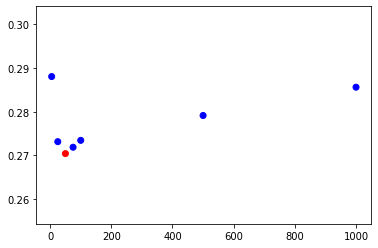

In [15]:
#The error in the first approach is quite high. Let us iterate to find the optimal tree parameters

candidate_max_leaf_nodes = [5, 25, 50,75, 100, 500,1000]
# Write loop to find the ideal tree size from candidate_max_leaf_nodes
mse=[]
for x in candidate_max_leaf_nodes:
    mse.append(get_mse_tree(x,train_X, test_X, train_y, test_y))

# Store the best value of max_leaf_nodes 
best_tree_size = candidate_max_leaf_nodes[mse.index(min(mse))]

#Show the minimum mse highlighted in red
minMse = np.min(mse)
mask = np.array(mse) == minMse
color = np.where(mask, 'red', 'blue')
plt.scatter(candidate_max_leaf_nodes,mse, color=color)


In [16]:
#Create tree model with the best max_leaf_nodes
improved_tree_model = DecisionTreeClassifier(max_leaf_nodes=best_tree_size, random_state=1)

# fit the final model with the whole dataset and calculate error
improved_tree_model.fit(train_X, train_y)
val_predictions = improved_tree_model.predict(test_X)
val_mse = mean_squared_error(val_predictions, test_y)
print("Validation MSE: {:,.5f} - Best tree size: {:,.0f}".format(val_mse,best_tree_size))

Validation MSE: 0.27043 - Best tree size: 50


In [17]:
#Print the score for the model with an improved leaf nodes size
improved_tree_model.score(test_X,test_y)

0.7295729310925628

In [18]:
#Let us use Randomized Grid search to optimize several hyperparameters

# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_leaf_nodes" : randint(1,300),
              "max_depth": [3, None],
              "max_features": randint(1, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}

# Instantiate the RandomizedSearchCV object: tree_cv
tree_cv = RandomizedSearchCV(tree_model, param_dist, cv=5, random_state=1)

# Fit it to the data
tree_cv.fit(train_X,train_y)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))


Tuned Decision Tree Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 7, 'max_leaf_nodes': 51, 'min_samples_leaf': 5}
Best score is 0.7278602620087337


In [19]:
#Create tree model with the best hyperparameters
best_tree_model = DecisionTreeClassifier(max_leaf_nodes=51, criterion='gini', max_depth=None, max_features=7,
                                         min_samples_leaf=7, random_state=0)

# fit the final model with the whole dataset and calculate error
best_tree_model.fit(train_X, train_y)
val_predictions = best_tree_model.predict(test_X)
val_mse = mean_squared_error(val_predictions, test_y)
print("Validation MSE: {:,.5f}".format(val_mse))

Validation MSE: 0.27372


In [20]:
print(confusion_matrix(test_y,val_predictions))
print(classification_report(test_y,val_predictions))

[[10118  2828]
 [ 4485  9286]]
              precision    recall  f1-score   support

           0       0.69      0.78      0.73     12946
           1       0.77      0.67      0.72     13771

    accuracy                           0.73     26717
   macro avg       0.73      0.73      0.73     26717
weighted avg       0.73      0.73      0.73     26717



In [21]:
#Also check the model with cross validation and store the mean of the values as the score of the model
cross_val_score(best_tree_model, X, y, cv=10)

array([0.72814371, 0.7255988 , 0.73263473, 0.73199581, 0.72615661,
       0.7345411 , 0.72450966, 0.7345411 , 0.72361132, 0.72312069])

In [22]:
model_score['DecisionTree'] =  [np.mean(cross_val_score(best_tree_model, test_X, test_y, cv=10))]

The result is the same as only tuning the max_leaf_nodes parameter. In this case we see that the number of leaf_nodes was 50, which is very close to the current value 51.

In [23]:
model_score

,DecisionTree
Model Score,0.726244


**Random Forest**

In [24]:
# Create target object and call it y
y = df_stroke['Target']
# Create X
#features = ['Age', 'Sex', 'SystolicPressure', 'Cholesterol', 'Diabetes']
features = ['Age', 'Sex', 'Height', 'Weight','SystolicPressure', 'DiastolicPressure', 'Cholesterol', 'Diabetes', 'Smoker', 'Alcoholic',
           'ActiveSport']
X = df_stroke[features]

In [25]:
from sklearn.ensemble import RandomForestClassifier

# Define the model. Set random_state to 1
rf_model = RandomForestClassifier(random_state=1)

# fit the model
rf_model.fit(train_X,train_y)

# Calculate the mean squared error of your Random Forest model on the validation data
predict_y=rf_model.predict(test_X)
rf_val_mse = mean_squared_error(test_y,predict_y)

print("Validation MSE for Random Forest Model: {}".format(rf_val_mse))


Validation MSE for Random Forest Model: 0.31511771531234795


In [26]:
#We define a function that returns the Mean squared error of the Random Forest. We will check for this purpose
# two parameters of the Random Forest regressor, the depth and the leaf nodes
def get_mse_forest(max_depth, max_leaf_nodes, train_X, test_X, train_y, test_y):
    model = RandomForestClassifier(max_depth=max_depth, max_leaf_nodes=max_leaf_nodes, random_state=0)
    model.fit(train_X, train_y)
    preds_val = model.predict(test_X)
    mse = mean_squared_error(test_y, preds_val)
    return(mse)

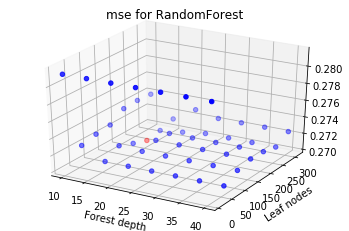

In [27]:
#Let us iterate to find the optimal forest parameters

step_leaf_nodes = 50
step_depth = 5
candidate_max_leaf_nodes = np.arange(10,(step_leaf_nodes*7)+10,step_leaf_nodes)
candidate_max_depth = np.arange(10,(step_depth*7)+10,step_depth)

# Write loop to find the ideal forest size from candidate_max_leaf_nodes and max_depth
mse=[]
depth_points=[]
leaf_points=[]
min_mse=1
for i, x_i  in enumerate(candidate_max_depth):
    for j, y_i  in enumerate(candidate_max_leaf_nodes):
        depth_points.append(candidate_max_depth[i])
        leaf_points.append(candidate_max_leaf_nodes[j])
        mse.append(get_mse_forest(x_i, y_i, train_X, test_X, train_y, test_y))
        if min(mse) < min_mse:
            min_mse = min(mse)
            # Store the best value of max_leaf_nodes and tree size
            best_depth = candidate_max_depth[i]
            best_forest_size = candidate_max_leaf_nodes[j]

#Show the minimum mse highlighted in red and plot in 3D the mse corresponding to the leaf nodes and depth fo the Random Forest
minmse = np.min(mse)
mask = np.array(mse) == minmse
color = np.where(mask, 'red', 'blue')
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(depth_points,leaf_points ,mse, color=color);
ax.set_title('mse for RandomForest');
ax.set_xlabel('Forest depth');
ax.set_ylabel('Leaf nodes');
#ax.set_zlim(zmin= 0.2, zmax=0.5)

In [28]:
#Create optimal random forest model
improved_forest_model = RandomForestClassifier(max_depth=best_depth, max_leaf_nodes=best_forest_size, random_state=0)

# fit the final model with the whole dataset and calculate error
improved_forest_model.fit(train_X, train_y)
val_predictions = improved_forest_model.predict(test_X)
val_mse = mean_squared_error(val_predictions, test_y)
print("Validation mse: {:,.5f} - Best depth: {:,.0f} - Best forest size: {:,.0f}".format(val_mse, best_depth,best_forest_size))

Validation mse: 0.27043 - Best depth: 15 - Best forest size: 210


In [29]:
#Let us use Randomized Grid search to optimize several hyperparameters

# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_leaf_nodes" : randint(1,300),
              "max_depth": [3, 40],
              "max_features": randint(1, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}

# Instantiate the RandomizedSearchCV object: forest_cv
forest_cv = RandomizedSearchCV(improved_forest_model, param_dist, cv=5, random_state=1)

# Fit it to the data
forest_cv.fit(train_X,train_y)

# Print the tuned parameters and score
print("Tuned Decision Forest Parameters: {}".format(forest_cv.best_params_))
print("Best score is {}".format(forest_cv.best_score_))

Tuned Decision Forest Parameters: {'criterion': 'gini', 'max_depth': 40, 'max_features': 4, 'max_leaf_nodes': 122, 'min_samples_leaf': 1}
Best score is 0.7310293200249532


In [30]:
#Create forest model with the best hyperparameters
best_forest_model = RandomForestClassifier(max_leaf_nodes=122, criterion='gini', max_depth=40, max_features=4,
                                         min_samples_leaf=1, random_state=0)

# fit the final model with the whole dataset and calculate error
best_forest_model.fit(train_X, train_y)
val_predictions = best_forest_model.predict(test_X)
val_mse = mean_squared_error(val_predictions, test_y)
print("Validation MSE: {:,.5f}".format(val_mse))

Validation MSE: 0.26972


In [31]:
print(confusion_matrix(test_y,val_predictions))
print(classification_report(test_y,val_predictions))

[[9833 3113]
 [4093 9678]]
              precision    recall  f1-score   support

           0       0.71      0.76      0.73     12946
           1       0.76      0.70      0.73     13771

    accuracy                           0.73     26717
   macro avg       0.73      0.73      0.73     26717
weighted avg       0.73      0.73      0.73     26717



In [32]:
#Also check the model with cross validation
cross_val_score(best_forest_model, X, y, cv=10)

array([0.72934132, 0.72919162, 0.73997006, 0.73499027, 0.72855218,
       0.73499027, 0.72750412, 0.73858362, 0.72121575, 0.72641509])

In [33]:
model_score['RandomForest'] =  [np.mean(cross_val_score(best_forest_model, test_X, test_y, cv=10))]

In [34]:
model_score

,DecisionTree,RandomForest
Model Score,0.726244,0.727253


### Logistic regression

In [35]:
from sklearn.linear_model import LogisticRegression
log = LogisticRegression()
log.fit(train_X, train_y)

# Predicting the Test set results
val_predictions = log.predict(test_X)

val_mse = mean_squared_error(val_predictions, test_y)
print("Validation MSE: {:,.5f}".format(val_mse))

Validation MSE: 0.28076


Text(0.5, 1.0, 'ROC Curve')

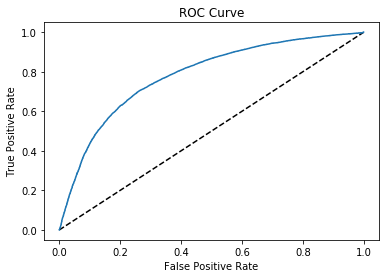

In [36]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Compute predicted probabilities: y_pred_prob
y_pred_prob = log.predict_proba(test_X)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(test_y, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

In [37]:
#We compute the area under the ROC
roc_auc_score(test_y, y_pred_prob)

0.7818791631780876

In [38]:
#Let us check the best performance using a grid search
# Setup the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space}

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(log, param_grid, cv=5)

# Fit it to the data
logreg_cv.fit(train_X,train_y)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))


Tuned Logistic Regression Parameters: {'C': 2275.845926074791}
Best score is 0.7217217716781036


In [39]:
#Create logistic regression model with the best hyperparameters
best_logistic_model = LogisticRegression(C=3.727593720314938, random_state=0)

# fit the final model with the whole dataset and calculate error
best_logistic_model.fit(train_X, train_y)
val_predictions = best_logistic_model.predict(test_X)
val_mse = mean_squared_error(val_predictions, test_y)
print("Validation MSE: {:,.5f}".format(val_mse))

Validation MSE: 0.28151


In [40]:
print(confusion_matrix(test_y,val_predictions))
print(classification_report(test_y,val_predictions))

[[9607 3339]
 [4182 9589]]
              precision    recall  f1-score   support

           0       0.70      0.74      0.72     12946
           1       0.74      0.70      0.72     13771

    accuracy                           0.72     26717
   macro avg       0.72      0.72      0.72     26717
weighted avg       0.72      0.72      0.72     26717



In [41]:
#Also check the model with cross validation for the best logistic model
log_scores = cross_val_score(best_logistic_model, X, y, cv=10)

In [42]:
model_score['LogisticRegression'] =  [np.mean(log_scores)]

In [43]:
 model_score

,DecisionTree,RandomForest,LogisticRegression
Model Score,0.726244,0.727253,0.718095


### K-Neighbors

In [44]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

#For this model we are scaling, since for the neighbor model having comparable values should be more accurate

# Setup the pipeline steps: steps
steps = [('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier(n_neighbors=3))]
        
# Create the pipeline: pipeline
pipeline = Pipeline(steps)

# Fit the pipeline to the training set: knn_scaled
knn_scaled = pipeline.fit(train_X,train_y)

# Instantiate and fit a k-NN classifier to the unscaled data
knn_unscaled = KNeighborsClassifier(n_neighbors=3)
knn_unscaled.fit(train_X, train_y)

# Compute and print metrics
print('Accuracy with Scaling: {}'.format(knn_scaled.score(test_X,test_y)))
print('Accuracy without Scaling: {}'.format(knn_unscaled.score(test_X,test_y)))

# Predicting the Test set results
val_predictions = knn_scaled.predict(test_X)

val_mse = mean_squared_error(val_predictions, test_y)
print("Validation mse: {:,.5f}".format(val_mse))

Accuracy with Scaling: 0.6300108545121084
Accuracy without Scaling: 0.6622000973163155
Validation mse: 0.36999


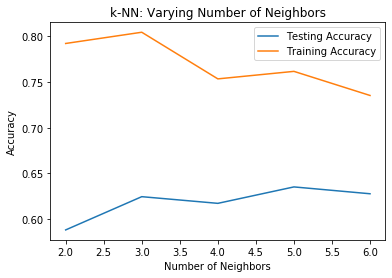

In [45]:

scaler = StandardScaler()

# Create X scaled
features = ['Age', 'Sex', 'Height', 'Weight','SystolicPressure', 'DiastolicPressure', 'Cholesterol', 'Diabetes', 'Smoker', 'Alcoholic',
           'ActiveSport']

X_scaled = scaler.fit_transform(X[features])
train_X, test_X, train_y, test_y = train_test_split(X_scaled, y, test_size=0.4, random_state=1)

#Let us iterate to find the best number of neighbors for the model and check performance for both training and test sets

neighbors = np.arange(2, 7)
train_accuracy = []
test_accuracy = []

# Loop over different values of k
for i, k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    # Fit the classifier to the training data
    knn.fit(train_X,train_y)    
    #Compute accuracy on the training set
    train_accuracy.append(knn.score(train_X, train_y))
    #Compute accuracy on the testing set
    test_accuracy.append(knn.score(test_X, test_y))

# Generate plot
plt.title('k-NN: Varying Number of Neighbors');
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy');
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy');
plt.legend()
plt.xlabel('Number of Neighbors');
plt.ylabel('Accuracy');


In [51]:
#We take the best number of neighbors based on the previous graph. We select a trade off between training and test accuracy
best_neighbors = 5

#Create optimal random forest model
best_neighbor_model = KNeighborsClassifier(n_neighbors=best_neighbors)

# fit the final model with the whole dataset and calculate error
best_neighbor_model.fit(train_X, train_y)
val_predictions = best_neighbor_model.predict(test_X)
val_mse = mean_squared_error(val_predictions, test_y)
print("Validation mse: {:,.5f} - Best number of neighbors: {:,.0f}".format(val_mse, best_neighbors))

Validation mse: 0.36475 - Best number of neighbors: 5


In [52]:
print(confusion_matrix(test_y,val_predictions))
print(classification_report(test_y,val_predictions))

[[8329 4617]
 [5128 8643]]
              precision    recall  f1-score   support

           0       0.62      0.64      0.63     12946
           1       0.65      0.63      0.64     13771

    accuracy                           0.64     26717
   macro avg       0.64      0.64      0.64     26717
weighted avg       0.64      0.64      0.64     26717



In [48]:
#Also check the model with cross validation
score_KNeighbors = cross_val_score(best_neighbor_model, X_scaled, y, cv=10)

In [49]:
model_score['K-Neighbors'] =  [np.mean(score_KNeighbors)]

In [50]:
model_score

,DecisionTree,RandomForest,LogisticRegression,K-Neighbors
Model Score,0.726244,0.727253,0.718095,0.641754


### Support Vector Machine (SVC)

In [84]:
from sklearn.svm import SVC
svc = SVC(kernel = 'rbf')
svc.fit(train_X, train_y)

# Predicting the Test set results
val_predictions = svc.predict(test_X)

val_mse = mean_squared_error(val_predictions, test_y)
print("Validation mse: {:,.3f}".format(val_mse))


Validation mse: 0.280


### Voting ensemble
We  combine the models to obtain a more accurate classifier

In [86]:
from sklearn.ensemble import VotingClassifier
# create the sub models, we select the three that perform better

estimators = []
estimators.append(('DecisionTree', best_tree_model))
estimators.append(('RandomForest', best_forest_model))
estimators.append(('LogisticRegression', best_logistic_model))

# create the ensemble model
ensemble = VotingClassifier(estimators)
ensembled_scores = cross_val_score(ensemble, X,y, cv=10)
model_score['EnsembledModels'] =  [np.mean(ensembled_scores)]
model_score

,DecisionTree,RandomForest,LogisticRegression,K-Neighbors,Ensembled_models,EnsembledModels
Model Score,0.726244,0.727253,0.718095,0.641754,0.729399,0.73121


In [79]:
final_scores = pd.DataFrame(model_score).transpose()

In [80]:
final_scores.sort_values(by='Model Score' ,ascending=False, inplace=True)
final_scores

,Model Score
Ensembled_models,0.729399
RandomForest,0.727253
DecisionTree,0.726244
LogisticRegression,0.718095
K-Neighbors,0.641754


### Light GBM

In [108]:
import lightgbm as lgb

d_train = lgb.Dataset(train_X, label = train_y)
params = {}

clf = lgb.train(params, d_train, 100)
#Prediction
val_predictions = clf.predict(test_X)

val_mse = mean_squared_error(val_predictions, test_y)
print("Validation mse: {:,.3f}".format(val_mse))

Validation MAE: 0.359


### Naive Bayes

In [12]:

from sklearn.naive_bayes import GaussianNB
gaussModel = GaussianNB()
gaussModel.fit(train_X, train_y)

# Predicting the Test set results
val_predictions = gaussModel.predict(test_X)

val_mse = mean_squared_error(val_predictions, test_y)
print("Validation mse: {:,.3f}".format(val_mse))


Validation MAE: 0.463


### XGBoost model

In [23]:
import xgboost as xgb
from xgboost import XGBRegressor

features = ['Id','Age', 'Sex', 'Height', 'Weight','SystolicPressure', 'DiastolicPressure', 'Cholesterol', 'Smoker', 'Alcoholic',
           'ActiveSport']
X = df_stroke2[features]

# Split into validation and training data
train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=1)

In [26]:
xgbModel = XGBRegressor(random_state=0, n_estimators=1000, learning_rate=0.1)

xgbModel.fit(train_X,train_y)

[19:59:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [27]:
val_predictions = xgbModel.predict(test_X)
val_mse = mean_squared_error(val_predictions, test_y)
print("Validation mse: {:,.3f}".format(val_mse))

Validation MAE: 0.361
